# Load packages

In [132]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# System libraries
import os
import sys
import h5py
os.environ["GDAL_DATA"] = '/Users/ccroberts/opt/anaconda3/envs/fresh/share/gdal' # need to specify to make gdal work
os.environ["PROJ_LIB"] = '/Users/ccroberts/opt/anaconda3/envs/fresh/share/proj' # need to specify to make pyproj work
os.environ["PROJ_DATA"] = '/Users/ccroberts/opt/anaconda3/envs/fresh/share/proj' # need to specify to make pyproj work

#Standard libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rx

#For geometries
import shapely
from shapely import box, LineString, MultiLineString, Point, Polygon
from shapely.geometry.polygon import orient

#Datetime
from datetime import datetime
from datetime import timedelta
from datetime import timezone
from dateutil.relativedelta import relativedelta
import time

#For plotting, ticking, and line collection
from matplotlib import cm 
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import cmcrameri.cm as cmc
import contextily as cx
# for legend
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerTuple

#Personal and application specific utilities
from utils.nsidc import download_is2
#from utils.S2 import plotS2cloudfree, add_inset, convert_time_to_string
from utils.utilities import is2dt2str
import pyTMD

#For error handling
import shutil
import traceback

# not in use 
from ipyleaflet import Map, basemaps, Polyline, GeoData, LayersControl
from rasterio import warp
from rasterio.crs import CRS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Specify the region

<Axes: >

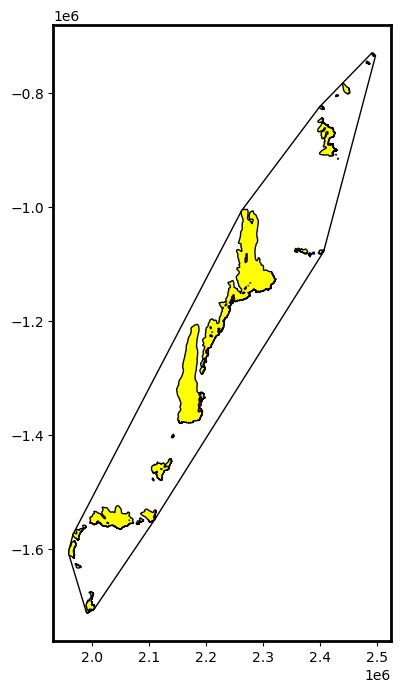

In [121]:
## Set params ##
basin = 'Cp-D'
region='all'


################## Plot subsetting geometry #############
#shape for the subsetting
shape = f'shapes/{basin}_{region}.shp'
#shape for the outline of the pinning point
pts = f'shapes/{basin}_{region}_pp.shp'
plot_dir = 'plots'
crs_antarctica = 'EPSG:3031'
crs_latlon = 'EPSG:4326'
short_name = 'ATL11'
output_dir = f'data/is2/{short_name}_{shape[:shape.rfind('.')].split('/')[-1]}'
gdf = gpd.read_file(shape).set_crs(crs_latlon, allow_override=True).to_crs(crs_antarctica)
gdf_ext = gpd.GeoDataFrame(geometry=[gdf.apply(lambda p: Polygon(p.geometry.exterior.coords), axis=1).unary_union],
    crs=crs_antarctica)
gdf = gpd.GeoDataFrame(geometry=[gdf.unary_union], crs=crs_antarctica)
pp_gdf = gpd.read_file(pts).set_crs(crs_latlon, allow_override=True).to_crs(crs_antarctica)

# plot the geometries
fig1, ax1 = plt.subplots(figsize=[10, 8])
gdf.convex_hull.plot(ax=ax1, color='None', edgecolor='black')
pp_gdf.plot(ax=ax1, color='red', edgecolor='black')
gdf.plot(ax=ax1, color='yellow', edgecolor='black')


# Define a bunch of functions

In [29]:
def download_data():
    uid,pw,eml = getedcreds()
    output_dir = f'data/is2/{short_name}_{shape[:shape.rfind('.')].split('/')[-1]}'
    download_is2(short_name='ATL11', uid=uid, pwd=pw, email=eml, output_dir=output_dir, shape=shape, shape_subset=shape)
    print('saved files to %s' % output_dir)
    return output_dir

def get_file_info():
    search_for = '%s_' % short_name
    search_in = output_dir + '/'
    filelist = [search_in+f for f in os.listdir(search_in) \
                if os.path.isfile(os.path.join(search_in, f)) & (search_for in f) & ('.h5' in f)]
    filelist.sort()
    print('There are %i files.' % len(filelist))
    
    dirdict = dict([(x,'ascending') for x in [1,2,3,12,13,14]] + \
                   [(x,'descending') for x in [5,6,7,8,9,10]] + \
                   [(x,'turning') for x in [4,11]])
    df_files = pd.DataFrame({'filename': filelist})
    df_files['granule_id'] = df_files.apply(lambda x: x.filename[x.filename.rfind(search_for):], axis=1)
    df_files['tides_filename'] = df_files.apply(lambda x: f'{output_dir}/tides/ATL11_CATS2008-v2023_TIDES_{x.granule_id[6:]}', axis=1)
    df_files['track'] = df_files.apply(lambda x: int(x.granule_id[6:10]), axis=1)
    df_files['region'] = df_files.apply(lambda x: int(x.granule_id[10:12]), axis=1)
    df_files['direction'] = df_files.apply(lambda x: dirdict[x.region], axis=1)
    df_files['cycles'] = df_files.apply(lambda x: '%s-%s' % (x.granule_id[13:15],x.granule_id[15:17]), axis=1)
    df_files['version'] = df_files.apply(lambda x: int(x.granule_id[18:21]), axis=1)
    df_files['release'] = df_files.apply(lambda x: int(x.granule_id[22:24]), axis=1)
    return df_files

def getedcreds():
    # change your credentials here, do not push them to github! 
    uid = 'ccroberts'
    pwd = 'pwd'
    email = 'ccroberts@ucsd.edu'

    # to print a message if they haven't been changed
    if uid == '<your_nasa_earthdata_user_id>':
        print('\n WARNING: YOU NEED TO SET UP YOUR NASA EARTHDATA CREDENTIALS TO DOWNLOAD ICESAT-2 DATA!\n')
        print('  update the info in ed/edcreds.py :\n')
        print("  def getedcreds():")
        print("    # change your credentials here, do not push them to github!")
        print("    uid = '<your_nasa_earthdata_user_id>'")
        print("    pwd = '<your_nasa_earthdata_password>'")
        print("    email = '<your_nasa_earthdata_account_email>'")
        return None
    else:
        return uid, pwd, email

def is2dt2str(lake_mean_delta_time):
    lake_mean_delta_time = np.mean(lake_mean_delta_time)
    if np.isnan(lake_mean_delta_time) | (lake_mean_delta_time == np.inf):
        return np.nan
    else:
        ATLAS_SDP_epoch_datetime = datetime(2018, 1, 1, tzinfo=timezone.utc)
        ATLAS_SDP_epoch_timestamp = datetime.timestamp(ATLAS_SDP_epoch_datetime)
        lake_mean_timestamp = ATLAS_SDP_epoch_timestamp + lake_mean_delta_time
        lake_mean_datetime = datetime.fromtimestamp(lake_mean_timestamp, tz=timezone.utc)
        time_format_out = '%Y-%m-%dT%H:%M:%SZ'
        is2time = datetime.strftime(lake_mean_datetime, time_format_out)
        return is2time

def set_axis_color(ax, axcolor):
    ax.spines['bottom'].set_color(axcolor)
    ax.spines['top'].set_color(axcolor) 
    ax.spines['right'].set_color(axcolor)
    ax.spines['left'].set_color(axcolor)
    ax.tick_params(axis='x', colors=axcolor)
    ax.tick_params(axis='y', colors=axcolor)
    ax.yaxis.label.set_color(axcolor)
    ax.xaxis.label.set_color(axcolor)
    ax.title.set_color(axcolor)

def get_ground_tracks(datadict):
    crs_latlon = 'EPSG:4326'
    gts = []
    for k in datadict.keys():
        ds = datadict[k]
        gdf_gt = gpd.GeoDataFrame(geometry=gpd.points_from_xy(ds.longitude, ds.latitude), crs=crs_latlon)
        #for 3d geometry
        #gdf_gt = gpd.GeoDataFrame(geometry=gpd.points_from_xy(ds.longitude, ds.latitude, ds.h_ano.sel(track=ds.track.data[0], pt=k).mean(dim='cycle_number')), crs=crs_latlon)
        gdf_gt['pt'] = k
        gts.append(gdf_gt)
    gdf_gts = gpd.GeoDataFrame(geometry=pd.concat(gts).groupby(['pt'])[['geometry']].apply(lambda x: LineString(x.geometry.tolist()))
        ).reset_index().set_crs(crs_latlon)
    colordict = {'col0': 'darkblue', 'col1': 'rebeccapurple', 'col2': 'palevioletred', 'col3': 'thistle'}
    gdf_gts['plotcolor'] = gdf_gts.apply(lambda x: colordict['col%s' % (int(x.pt[2])-1)], axis=1)
    gdf_gts['track'] = ds.track.data[0]
    
    return gdf_gts

def read_atl11(filename, track, verbose=False):
    if verbose: print(f'reading track: {track}')
    with h5py.File(filename, 'r') as f:
        datadict = {}
        pts = [x for x in f.keys() if 'pt' in x]
        for pt in pts:
            try:
                vars_data = ['delta_time', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'quality_summary']
                vars_coords = ['cycle_number', 'latitude', 'longitude','ref_pt']
                ds = xr.Dataset({**{v: (['x', 'cycle_number', 'track', 'pt'], f[pt][v][()][:, :, np.newaxis, np.newaxis]) for v in vars_data},
                    'geoid': (['x', 'track', 'pt'], f[pt]['ref_surf/geoid_h'][()][:, np.newaxis, np.newaxis])},
                    coords={'cycle_number': f[pt]['cycle_number'][()],
                    **{v : ('x', f[pt][v][()]) for v in vars_coords[1:]}})
                ds.coords['x'], ds['track'], ds['pt'] = np.arange(len(ds.x)), [track], [pt]
                ds = ds.assign_coords(x_atc=('x', np.arange(len(f[pt]['latitude'][()])) * 60))
                h_arr = np.array(ds.h_corr-ds.geoid)# go to numpy for 2-d boolean indexing
                h_arr[ds.quality_summary>0] = np.nan
                h_arr[(h_arr>2e2)+(h_arr<-50)] = np.nan
                ds['h_corr'] = (ds.h_corr.dims, h_arr)
                ds['h_corr'] = ds.h_corr+ds.geoid
                datadict[pt] = ds
            #except KeyError as e:
            #    print(f"KeyError: The key {e} was not found in the data source.")
            #except ValueError as e:
            #    print(f"ValueError: {e}")
            #except Exception as e:
            #    print(f"An unexpected error occurred: {e}")
            except: continue
    return datadict

def read_atl11_tides(filename, track):
    with h5py.File(filename, 'r') as f:
        tidedict = {}
        pts = [x for x in f.keys() if 'pt' in x]
        for pt in pts:
            vars_data = ['delta_time', 'cycle_stats/tide_ocean']
            vars_coords = ['cycle_number', 'latitude', 'longitude', 'ref_pt']
            ds = xr.Dataset({v: (['x', 'cycle_number', 'track', 'pt'], f[pt][v][()][:, :, np.newaxis, np.newaxis]) for v in vars_data}, 
                    coords={'cycle_number': f[pt]['cycle_number'][()],
                    **{v : ('x', f[pt][v][()]) for v in vars_coords[1:]}})
            ds.coords['x'], ds['track'], ds['pt'] = np.arange(len(ds.x)), [track], [pt]
            ds = ds.assign_coords(x_atc=('x', np.arange(len(f[pt]['latitude'][()])) * 60))
            ds = ds.rename({'cycle_stats/tide_ocean': 'tide_cats'})
            tide_cats = np.array(ds.tide_cats) # go to numpy for 2-d boolean indexing
            tide_cats[tide_cats>1e5]=np.nan
            ds['tide_cats'] = (ds.tide_cats.dims, tide_cats)
            ds['tide_cats'] = ds.tide_cats.interpolate_na(dim='x', method='linear').interpolate_na(dim='x', method='nearest', fill_value='extrapolate')
            tidedict[pt] = ds
    return tidedict

def get_data(track, verbose=False):
    # get the data
    filename = df_files[df_files.track == track].filename.iloc[0]
    tides_filename = df_files[df_files.track == track].tides_filename.iloc[0]
    datadict = read_atl11(filename, track, verbose)
    tidedict = read_atl11_tides(tides_filename, track)
    datadict = {pt: xr.merge([datadict[pt], tidedict[pt]], join='inner', compat='override') for pt in datadict}
    datadict = {pt: datadict[pt].assign(h_abs=(('x', 'cycle_number', 'track', 'pt'), 
        (datadict[pt]['h_corr']-datadict[pt]['geoid']-datadict[pt]['tide_cats']).data)) for pt in datadict}
    datadict = {pt: datadict[pt].assign(h_ano=(('x', 'cycle_number', 'track', 'pt'),
        (datadict[pt].h_abs-datadict[pt].h_abs.median(dim='cycle_number')).data)) for pt in datadict}
    gdf_gts = get_ground_tracks(datadict).to_crs(crs_antarctica)
    return datadict, gdf_gts

def clip_data(datadict, gdf_gts, mask):
    #clip through rectangle is faster
    datadict_clipped = {}
    gdf_gts_clipped_list = []
    for pt in datadict:
        ds=datadict[pt]
        #select pt
        gdf_this = gdf_gts[gdf_gts.pt==pt]
        #convert linestring to points
        gdf_this_pts = gpd.GeoDataFrame(geometry=gdf_gts[gdf_gts.pt==pt].get_coordinates(ignore_index=True).apply(lambda l: Point(l), axis=1), 
            crs=crs_antarctica)
        gdf_clipped = gdf_this_pts.clip(mask.clip(gdf_this.bounds.values[0]))
        try: gdf_gts_clipped_list.append(gdf_this.clip(mask))
        except: continue
        datadict_clipped[pt] = ds.sel(x=(gdf_clipped.index))
    return datadict_clipped, pd.concat(gdf_gts_clipped_list, ignore_index=True)

def get_ds_dict(tracklist, mask=None):
    ds_list, gdf_gts_clipped_list = [], []
    for t in tracklist: 
        datadict, gdf_gts_clipped = get_data(t)
        if mask is not None: datadict, gdf_gts_clipped = clip_data(datadict, gdf_gts_clipped, mask)
        ds_add = xr.concat([datadict[pt] for pt in datadict], dim='pt')
        ds_add['x'] = np.arange(len(ds_add.x))
        ds_list.append(ds_add.sortby('x'))
        gdf_gts_clipped_list.append(gdf_gts_clipped)
    print('generating dict and gdf')
    return {ds.track.values[0]: ds for ds in ds_list}, pd.concat(gdf_gts_clipped_list, ignore_index=True)

def combine_ds_dict(ds_dict):
    ds_list = []
    for t in ds_dict:
        ds = ds_dict[t]
        if len(ds.x)!=0: 
            ds['x'] = np.arange(len(ds.x))
            ds_list.append(ds)
    return xr.concat(ds_list, dim='track')

def get_stats(tracklist, mask=None):
    ds_list = []
    gdf_gts_list = []
    for t in tracklist:
        datadict, gdf_gts_clipped = get_data(t)
        # subset here
        if mask is not None: datadict, gdf_gts_clipped = clip_data(datadict, gdf_gts_clipped, mask)
        gdf_gts_list.append(gdf_gts_clipped)
        for pt in datadict:
            try:
                ds = datadict[pt]
                h_abs = ds.h_corr - ds.geoid - ds.tide_cats
                coords_dict = {'cycle_number': ds.cycle_number.data,
                 'track': ds.track.data,
                 'pt': ds.pt.data}
                stat_dict = {'h_min': h_abs.min(dim='x'), 
                 'h_max': h_abs.max(dim='x'), 
                 'h_sum': h_abs.sum(dim='x'),
                 'h_mean': h_abs.mean(dim='x'), 
                 'h_med': h_abs.median(dim='x'), 
                 'h_ano': ds.h_ano.median(dim='x'),
                 'h_std': h_abs.std(dim='x', skipna=True, ddof=1),
                 'h_var': h_abs.var(dim='x', skipna=True, ddof=1), 
                 't_count': h_abs.count(dim='x'), 
                 'pct_nan': h_abs.count(dim='x')/h_abs.sizes['x'], 
                 't_dist': h_abs.count(dim='x')*0+h_abs.x_atc.max()/1000,
                 'tide_min': ds.tide_cats.min(dim='x'),
                 'tide_max': ds.tide_cats.max(dim='x'),
                 'tide_mean': ds.tide_cats.mean(dim='x'),
                 'tide_sum': ds.tide_cats.sum(dim='x')}
                dss = xr.Dataset({v: (['cycle_number', 'track', 'pt'], stat_dict[v].data) for v in stat_dict}, coords={v: coords_dict[v] for v in coords_dict})
                ds_list.append(dss)
            except: 
                continue
            #except KeyError as e:
            #    print(f'failed for track {t}, {pt}')
            #    print(f"KeyError: The key {e} was not found in the data source.")
            #except ValueError as e:
            #    print(f'failed for track {t}, {pt}')
            #    print(f"ValueError: {e}")
            #except Exception as e:
            #    print(f'failed for track {t}, {pt}')
            #    print(f"An unexpected error occurred: {e}")
    return xr.combine_by_coords(data_objects=ds_list), pd.concat(gdf_gts_list, ignore_index=True)
        

def retry(num_attempts=1, sleep_time=5):
    for i in range(num_attempts): 
        try: 
            download_data()
            print(f'success on attempt {i}')
            return
        except Exception as e:
            if i==num_attempts-1:
                print(f"The following error occurred: {e}")
                traceback.print_exc()
            time.sleep(sleep_time)
    return


# Grab the data

In [6]:
%%time
# comment out after downloading 
#retry(20, 20)
#download_data()

df_files = get_file_info()
df_files;

There are 189 files.
CPU times: user 19.7 ms, sys: 6.72 ms, total: 26.4 ms
Wall time: 34.4 ms


In [123]:
#track=26
track=727
#track=1077
datadict, gdf_gts = get_data(track)
datadict, gdf_gts = clip_data(datadict, gdf_gts, gdf)
pt = 'pt3'
ds = datadict[pt]

In [148]:
gdf_gts.geometry[0].geoms()

TypeError: 'GeometrySequence' object is not callable

In [133]:
line_list = []
for geom in gdf_gts.geometry:
     if isinstance(geom, MultiLineString):
            for line in geom:
                line_list.append(line)

TypeError: 'MultiLineString' object is not iterable

In [130]:
line_list

[<MULTILINESTRING ((2224757.787 -1167679.24, 2224795.333 -1167693.695, 222485...>,
 <MULTILINESTRING ((2225000.065 -1171433.534, 2225029.096 -1171445.039, 22250...>,
 <MULTILINESTRING ((2228088.109 -1176265.371, 2228092.251 -1176266.666, 22281...>]

In [7]:
%%time

# Get_stats
tracklist=[33, 26, 155, 727, 1077]
dss_short, gdf_gts_short_all = get_stats(tracklist, gdf)
dss_short_pp, gdf_gts_short_all_pp = get_stats(tracklist, pp_gdf)

/Users/ccroberts/opt/anaconda3/envs/fresh/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/ccroberts/opt/anaconda3/envs/fresh/lib/python3.12/site-packages/xarray/core/nputils.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/ccroberts/opt/anaconda3/envs/fresh/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/ccroberts/opt/anaconda3/envs/fresh/lib/python3.12/site-packages/xarray/core/nputils.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/ccroberts/opt/anaconda3/envs/fresh/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <=

CPU times: user 4.3 s, sys: 206 ms, total: 4.5 s
Wall time: 4.76 s


/Users/ccroberts/opt/anaconda3/envs/fresh/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/ccroberts/opt/anaconda3/envs/fresh/lib/python3.12/site-packages/xarray/core/nputils.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [6]:
%%time

# Get_ds_dict
tracklist=[33, 26, 155, 727, 1077]
ds_dict_short, gdf_gts_short_all = get_ds_dict(tracklist, gdf)
ds_dict_pp, gdf_gts_short_all_pp = get_ds_dict(tracklist, pp_gdf)

generating dict and gdf
generating dict and gdf
CPU times: user 4.04 s, sys: 199 ms, total: 4.24 s
Wall time: 4.4 s


In [10]:
%%time
# Get_stats
tracklist=df_files.track
dss, gdf_gts_all = get_stats(tracklist, gdf)
dss_pp, gdf_gts_all_pp = get_stats(tracklist, pp_gdf)

/Users/ccroberts/opt/anaconda3/envs/fresh/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/ccroberts/opt/anaconda3/envs/fresh/lib/python3.12/site-packages/xarray/core/nputils.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/ccroberts/opt/anaconda3/envs/fresh/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/ccroberts/opt/anaconda3/envs/fresh/lib/python3.12/site-packages/xarray/core/nputils.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/ccroberts/opt/anaconda3/envs/fresh/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <=

CPU times: user 2min 38s, sys: 6.75 s, total: 2min 45s
Wall time: 2min 55s


/Users/ccroberts/opt/anaconda3/envs/fresh/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/ccroberts/opt/anaconda3/envs/fresh/lib/python3.12/site-packages/xarray/core/nputils.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [8]:
%%time

# Get_ds_dict
tracklist=df_files.track
ds_dict, gdf_gts_all_ext = get_ds_dict(tracklist, gdf_ext)
#ds_dict_pp, gdf_gts_all_pp_1 = get_ds_dict(tracklist, pp_gdf)

# Combine for full dataset
ds_all = combine_ds_dict(ds_dict)
#ds_all_pp = combine_ds_dict(ds_dict_pp)

generating dict and gdf
CPU times: user 1min 31s, sys: 4.22 s, total: 1min 35s
Wall time: 1min 40s


# Plot map

In [69]:
#Calculate value to plot
h_ano_lin = ds_all.h_ano.polyfit('cycle_number', deg=1)

<xarray.DataArray 'polyfit_coefficients' (x: 1316)> Size: 11kB
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * x        (x) int64 11kB 0 1 2 3 4 5 6 ... 1309 1310 1311 1312 1313 1314 1315
    track    int64 8B 18
    pt       <U3 12B 'pt1'
    degree   int64 8B 1

In [118]:
## make plot function
def make_plot(color_by='', dpi=600, vlims=[-5, 5], imagery_resolution_adjust=1, save=False):
    # figure setup
    imagery_aspect = 1.3
    major_font_size = 8
    minor_font_size = 7
    line_w = 0.7

    vlims = [-3, 3]
    
    # make figure and axes
    fig = plt.figure(figsize=[9,5], dpi=dpi)
    gs = fig.add_gridspec(3, 10)
    axs = [fig.add_subplot(gs[:, :4])]
    for i in range(3):
        axs.append(fig.add_subplot(gs[i, 5:10]))
    #axs.append(fig.add_subplot(gs[:, 11:]))
    boxprops = dict(boxstyle='round', facecolor='none', alpha=0.5, edgecolor='none', pad=0.2)
    
    # plot the basemap and ground track
    # We do this using the package `contextily`, which provides basemaps for plotting in matplotlib. 
    # Here we use ESRI's WordImagery basemap. 
    ax = axs[0]
    
    buffer = 0.001 * np.max([gdf.total_bounds[i+2] - gdf.total_bounds[i] for i in [0,1]])
    bbox = np.array(box(*gdf.total_bounds).buffer(buffer).bounds)
    xrng = bbox[2] - bbox[0]
    yrng = xrng*imagery_aspect
    ymid = np.mean(bbox[[1,3]])
    ax.set_xlim(bbox[[0,2]])
    ax.set_ylim([ymid - yrng/2, ymid + yrng/2])
    cx.add_basemap(ax=ax, crs=crs_antarctica, source=cx.providers.Esri.WorldImagery, 
        zoom_adjust=imagery_resolution_adjust, attribution=' ', attribution_size=4)
    #, attribution='imagery ©ESRI (WorldImagery)', attribution_size=4)
    txt = ax.texts[-1]
    txt.set_position([0.98,0.01])
    txt.set_ha('right')
    txt.set_va('bottom')
    
    #add ground tracks
    lc_list=[]
    if color_by is not None:
        for i in range(len(gdf_gts_all_ext)):
            row = gdf_gts_all_ext[i:i+1]
            coords = row.get_coordinates()
            cmap = cmc.vik_r
            t = row.track.iloc[0]
            pt = row.pt.iloc[0]
            # Prepare segments for LineCollection
            points = np.array([coords.x, coords.y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            # Create a LineCollection
            lc = LineCollection(segments, cmap=cmap, norm=plt.Normalize(vlims[0], vlims[1]))
            lc.set_array(h_ano_lin.sel(degree=1).sel(track=t, pt=pt).polyfit_coefficients)
            lc.set_linewidth(line_w)
            lc_list.append(lc)
            ax.add_collection(lc)
    elif color_by is None:
        gdf_gts_all.plot(ax=ax, color=gdf_gts_all.plotcolor, linewidth=line_w)
        gdf_gts_all_pp.plot(ax=ax, color='lightblue', linewidth=line_w)
                
    '''
    # pinning points
    for i in range(len(gdf_gts_all_pp)):
        row = gdf_gts_all_pp[i:i+1]
        coords = row.get_coordinates()
        if color_by is not None:
            cmap = cmc.vik
            t = row.track.iloc[0]
            pt = row.pt.iloc[0]
            # Prepare segments for LineCollection
            points = np.array([coords.x, coords.y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            # Create a LineCollection
            lc = LineCollection(segments, cmap=cmap, norm=plt.Normalize(vlims[0], vlims[1]))
            lc.set_array(ds_dict[t].h_ano.mean(dim='cycle_number').sel(track=t, pt=pt))
            lc.set_linewidth(line_w)
            lc_list.append(lc)
            ax.add_collection(lc)
        elif color_by is None:
            color=row.plotcolor
            vlims = [None, None]
            cmap=None
            ax.scatter(coords[:,0], coords[:,1], marker='.', s=line_w, c='lightblue', edgecolors='None')
    '''
    
    hdls = []
    pp_gdf.plot(ax=ax, color='None', edgecolor='black', label='grounded ice', linewidth=0.2, zorder=500)
    gdf.plot(ax=ax, color='None', edgecolor='royalblue', label='floating ice', linewidth=0.4, zorder=501)
    
    
    ax.axis('off')
    ax.text(0.5, 0.96, f'{basin} height change 2019-2024', transform=ax.transAxes, 
            ha='center', va='center', fontsize=major_font_size, bbox=boxprops, zorder=502)
        
    
    ax=axs[1]
    hdls = []
    
    # mean values
    ano_cycle = dss.h_ano.median(dim=['track', 'pt'])
    ano_cycle_std = dss.h_ano.std(dim=['track', 'pt'])
    ano_cycle_pp = dss_pp.h_ano.median(dim=['track', 'pt'])
    ax.axhline(y=0.0, linestyle='--', color='black')
    hdl = ax.plot(ano_cycle.cycle_number, (ano_cycle - ano_cycle.isel(cycle_number=0)), color='red', label='floating ice')
    hdls.append(hdl)
    hdl = ax.plot(ano_cycle_pp.cycle_number, (ano_cycle_pp - ano_cycle_pp.isel(cycle_number=0)), '-', color='lightblue', label='pinning points')
    hdls.append(hdl)
    # starting at 2 is 2019
    ax.set_xlim([2, 23])
    ax.set_ylim([-0.9, 0.9])
    ax.set_xticks(ticks=np.arange(2, 23), minor=True)
    ax.set_xticks(ticks=np.arange(2, 23, 4), labels=[])
    ax.set_yticks(ticks=[-0.5, 0.5])
    ax.tick_params(axis='x', which='major', length=5, width=2)
    ax.tick_params(axis='x', which='minor', length=3, width=1)
    ax.tick_params(axis='y', direction='in', zorder=1, labelsize=minor_font_size)
    ax.set_ylabel('height (m)', fontsize=minor_font_size, labelpad=-0.2)
    ax.text(0.5, 0.96, 'Median Height Change', transform=ax.transAxes, ha='center', va='top', 
        fontsize=major_font_size, bbox=boxprops)
    ax.legend(loc='lower left', fontsize=minor_font_size)
    
    ax=axs[2]
    
    #anomaly (data) count
    ano_count = dss.h_ano.count(dim=['track', 'pt'])
    ano_count_pp = dss_pp.h_ano.count(dim=['track', 'pt'])
    
    hdls = []
    ax.axhline(y=1.0, linestyle='--', color='black')
    hdl = ax.plot(ano_cycle.cycle_number, ano_count/ano_count.median(), color='red', label=f'mean = {ano_count.mean().data} values')
    hdls.append(hdl)
    hdl = ax.plot(ano_cycle_pp.cycle_number, ano_count_pp/ano_count_pp.median(), '-', color='lightblue', label=f'mean = {ano_count_pp.mean().data} values')
    hdls.append(hdl)
    ax.set_xlim([2, 23])
    ax.set_ylim([-0.0, 1.5])
    ax.set_ylabel('count fraction', fontsize=minor_font_size)
    ax.set_xticks(ticks=np.arange(2, 23), minor=True)
    ax.set_xticks(ticks=np.arange(2, 23, 4), labels=[f'{int(c)}' for c in np.arange(2019, 2025)])
    ax.tick_params(axis='x', which='major', length=5, width=2, labelsize=minor_font_size)
    ax.tick_params(axis='x', which='minor', length=3, width=1)
    ax.tick_params(axis='y', direction='in', zorder=1, labelsize=minor_font_size)
    ax.text(0.5, 0.96, 'Relative Count', transform=ax.transAxes, ha='center', va='top', fontsize=major_font_size, bbox=boxprops)
    ax.legend(loc='lower left', fontsize=minor_font_size)
    
    # remove extra axes if no data
    axs[3].axis('off')
    
    # Create a ScalarMappable with the same colormap and normalization
    norm = mcolors.Normalize(vmin=vlims[0], vmax=vlims[1])
    sm = cm.ScalarMappable(cmap=cmc.vik_r, norm=norm)
    sm.set_array([])  # Only needed for older versions of matplotlib
    
    
    
    # Add the inset axis
    pos = axs[0].get_position()
    cax_pos = [pos.x0+pos.width*0.63, pos.y0+0.13, pos.width*0.25, pos.height*0.02]
    cax = fig.add_axes(cax_pos)
    #fig.patches.append(Rectangle((cax_pos[0]-, cax_pos[1]), cax_pos[2]*1.25, cax_pos[3]*2,
    #    transform=fig.transFigure, color='white', zorder=1))
    
    # Add a colorbar to the plot, with a specific location
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal', fraction=0.1, pad=0.0)
    cbar.ax.tick_params(labelsize=minor_font_size) 
    cbar.set_label('height change \n(m yr$^{-1}$)', fontsize=minor_font_size)
    cbar.outline.set_edgecolor('white')
    cbar.outline.set_linewidth(0.5)
    set_axis_color(cax, 'white')
    
    # Customize the colorbar ticks if needed
    cbar.set_ticks([-2, 0, 2])
    #cbar.set_ticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'])
    
    plotname = '/Users/ccroberts/Desktop/Cp-D_tracks_4.png'
    if save: fig.savefig(plotname, dpi=dpi, bbox_inches='tight')
    
    plt.close(fig)

    return fig

In [119]:
%%time
fig = make_plot(color_by='', dpi=600, vlims=[-3, 3], imagery_resolution_adjust=1, save=False)
display(fig)

CPU times: user 6.16 s, sys: 224 ms, total: 6.39 s
Wall time: 6.47 s


(-3.0, 3.0)

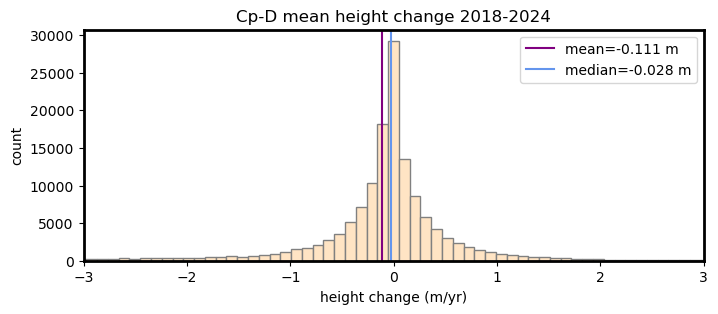

In [106]:
fig, ax = plt.subplots(figsize=[8, 3])
m = h_ano_lin.sel(degree=1).polyfit_coefficients
ax.hist(np.ndarray.flatten(m.data), 200, color='bisque', edgecolor='gray');
ax.axvline(x=m.mean(), label=f'mean={m.mean().round(3).data} m', color='purple')
ax.axvline(x=m.median(), label=f'median={m.median().round(3).data} m', color='cornflowerblue')
ax.set_ylabel('count')
ax.set_xlabel('height change (m/yr)')
ax.set_title('Cp-D mean height change 2018-2024')
ax.legend()
ax.set_xlim([-3, 3])

In [ ]:
# Cycle plots

In [ ]:
# compare anomaly methods
# Grid up the data
# plot the grid to see change

In [136]:
ds_all.count(dim=['track', 'pt']).max()

<xarray.Dataset> Size: 72B
Dimensions:                  ()
Data variables:
    delta_time               int64 8B 292
    h_corr                   int64 8B 174
    h_corr_sigma             int64 8B 292
    h_corr_sigma_systematic  int64 8B 292
    quality_summary          int64 8B 292
    geoid                    int64 8B 292
    tide_cats                int64 8B 240
    h_abs                    int64 8B 173
    h_ano                    int64 8B 173

In [139]:
ds_all.isel(cycle_number=4).count(dim=['track', 'pt'])

<xarray.Dataset> Size: 105kB
Dimensions:                  (x: 1316)
Coordinates:
    cycle_number             int8 1B 7
  * x                        (x) int64 11kB 0 1 2 3 4 ... 1312 1313 1314 1315
Data variables:
    delta_time               (x) int64 11kB 144 148 151 155 160 ... 1 1 1 1 1
    h_corr                   (x) int64 11kB 70 71 73 72 75 81 83 ... 1 1 1 1 1 1
    h_corr_sigma             (x) int64 11kB 144 148 151 155 160 ... 1 1 1 1 1
    h_corr_sigma_systematic  (x) int64 11kB 144 148 151 155 160 ... 1 1 1 1 1
    quality_summary          (x) int64 11kB 144 148 151 155 160 ... 1 1 1 1 1
    geoid                    (x) int64 11kB 144 148 151 155 160 ... 1 1 1 1 1
    tide_cats                (x) int64 11kB 97 101 103 105 109 117 ... 1 1 1 1 1
    h_abs                    (x) int64 11kB 68 69 71 70 73 79 81 ... 1 1 1 1 1 1
    h_ano                    (x) int64 11kB 68 69 71 70 73 79 81 ... 1 1 1 1 1 1

In [124]:
ds_all.h_ano.isel(cycle_number=1).count(dim=['track', 'pt'])

<xarray.DataArray 'h_ano' (x: 1316)> Size: 11kB
array([46, 49, 50, ...,  0,  0,  0])
Coordinates:
    cycle_number  int8 1B 4
  * x             (x) int64 11kB 0 1 2 3 4 5 6 ... 1310 1311 1312 1313 1314 1315

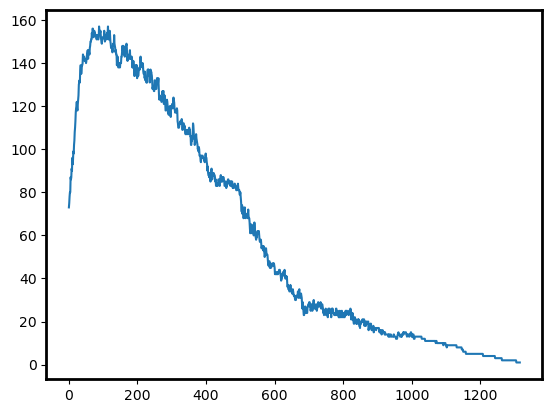

In [122]:
fig, ax = plt.figure(figsize=[7, 3])
ax.plot(ds_all.h_ano.isel(cycle_number=1).count(dim=['track', 'pt']))

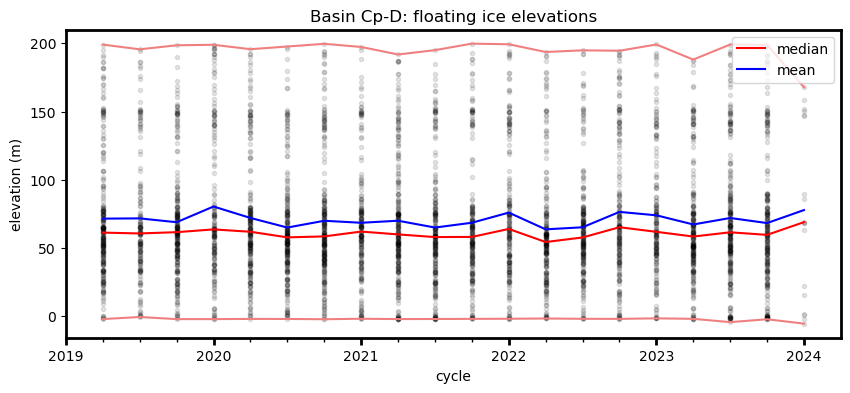

In [178]:
fig, ax = plt.subplots(figsize=[10, 4])
#plotdict = {f'ano_{t}_{pt}': dss.h_med.sel(track=t, pt=pt) for t in dss.track.values for pt in dss.pt.values}
#for p in plotdict: ax.plot(plotdict[p].cycle_number, plotdict[p], '.', color='black', alpha=0.1)
#ax.axhline(y=0.0, linestyle='--', color='black')
ax.plot(dss.cycle_number, dss.h_med.max(dim=['track', 'pt']), color='lightcoral')
ax.plot(dss.cycle_number, dss.h_med.median(dim=['track', 'pt']), color='red', label='median')
ax.plot(dss.cycle_number, dss.h_med.mean(dim=['track', 'pt']), color='blue', label='mean')
ax.plot(dss.cycle_number, dss.h_med.min(dim=['track', 'pt']), color='lightcoral')
#ax.plot(dss_pp.cycle_number, dss_pp.h_med.median(dim=['track', 'pt']), '-', color='royalblue', label='Cp-D pinning points')
# starting at 2 is 2019
ax.set_xlim([2, 23])
#ax.set_ylim([-4.5, 4.5])
#ax.set_ylim([-0.9, 0.9])

ax.set_xticks(ticks=np.arange(2, 23), minor=True)
ax.set_xticks(ticks=np.arange(2, 23, 4), labels=[f'{int(c)}' for c in np.arange(2019, 2025)])
ax.tick_params(axis='x', which='major', length=5, width=2)
ax.tick_params(axis='x', which='minor', length=3, width=1)
ax.tick_params(which='both', direction='out', zorder=1)

ax.set_xlabel('cycle')
ax.set_ylabel('elevation (m)')
ax.set_title('Basin Cp-D: floating ice elevations')
ax.legend()

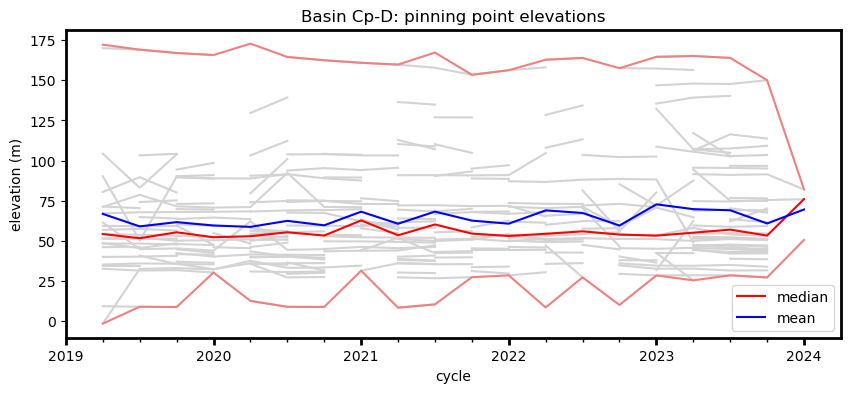

In [160]:
fig, ax = plt.subplots(figsize=[10, 4])
#plotdict = {f'ano_{t}_{pt}': dss_pp.h_med.sel(track=t, pt=pt) for t in dss_pp.track.values for pt in dss_pp.pt.values}
#for p in plotdict: ax.plot(plotdict[p].cycle_number, plotdict[p], color='lightgray')
#ax.axhline(y=0.0, linestyle='--', color='black')
ax.plot(dss_pp.cycle_number, dss_pp.h_med.max(dim=['track', 'pt']), color='lightcoral')
ax.plot(dss_pp.cycle_number, dss_pp.h_med.median(dim=['track', 'pt']), color='red', label='median')
ax.plot(dss_pp.cycle_number, dss_pp.h_med.mean(dim=['track', 'pt']), color='blue', label='mean')
ax.plot(dss_pp.cycle_number, dss_pp.h_med.min(dim=['track', 'pt']), color='lightcoral')
#ax.plot(dss_pp.cycle_number, dss_pp.h_med.median(dim=['track', 'pt']), '-', color='royalblue', label='Cp-D pinning points')
# starting at 2 is 2019
ax.set_xlim([2, 23])
#ax.set_ylim([-4.5, 4.5])
#ax.set_ylim([-0.9, 0.9])

ax.set_xticks(ticks=np.arange(2, 23), minor=True)
ax.set_xticks(ticks=np.arange(2, 23, 4), labels=[f'{int(c)}' for c in np.arange(2019, 2025)])
ax.tick_params(axis='x', which='major', length=5, width=2)
ax.tick_params(axis='x', which='minor', length=3, width=1)
ax.tick_params(which='both', direction='out', zorder=1)

ax.set_xlabel('cycle')
ax.set_ylabel('elevation (m)')
ax.set_title('Basin Cp-D: pinning point elevations')
ax.legend()

In [37]:
ano_cycle = dss.h_ano.median(dim=['track', 'pt'])
ano_cycle_std = dss.h_ano.std(dim=['track', 'pt'])
ano_cycle_pp = dss_pp.h_ano.median(dim=['track', 'pt'])

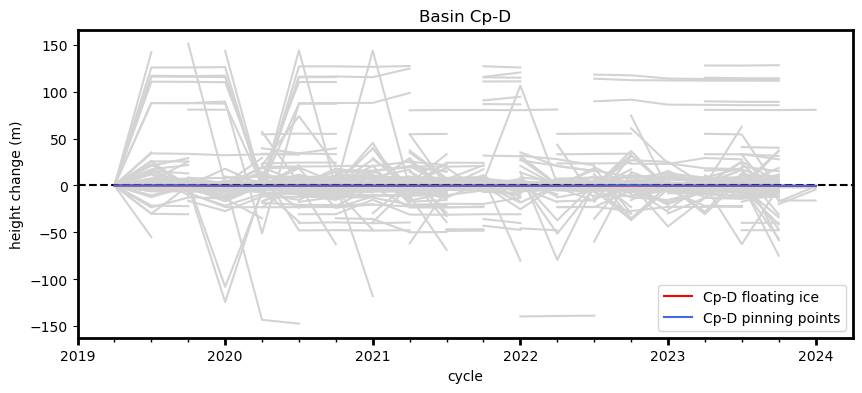

In [169]:
fig, ax = plt.subplots(figsize=[10, 4])
#plotdict = {f'ano_{t}_{pt}': dss.h_med.sel(track=t, pt=pt) for t in dss.track.values for pt in dss.pt.values}
#for p in plotdict: ax.plot(plotdict[p].cycle_number, (plotdict[p] - plotdict[p].sel(cycle_number=3)), color='lightgray')
ax.axhline(y=0.0, linestyle='--', color='black')
ax.plot(ano_cycle.cycle_number, (ano_cycle - ano_cycle.isel(cycle_number=0)), color='red', label='Cp-D floating ice')
ax.plot(ano_cycle_pp.cycle_number, (ano_cycle_pp - ano_cycle_pp.isel(cycle_number=0)), '-', color='royalblue', label='Cp-D pinning points')
# starting at 2 is 2019
ax.set_xlim([2, 23])
#ax.set_ylim([-4.5, 4.5])
#ax.set_ylim([-0.9, 0.9])

ax.set_xticks(ticks=np.arange(2, 23), minor=True)
ax.set_xticks(ticks=np.arange(2, 23, 4), labels=[f'{int(c)}' for c in np.arange(2019, 2025)])
ax.tick_params(axis='x', which='major', length=5, width=2)
ax.tick_params(axis='x', which='minor', length=3, width=1)
ax.tick_params(which='both', direction='out', zorder=1)

ax.set_xlabel('cycle')
ax.set_ylabel('height change (m)')
ax.set_title('Basin Cp-D')
ax.legend()

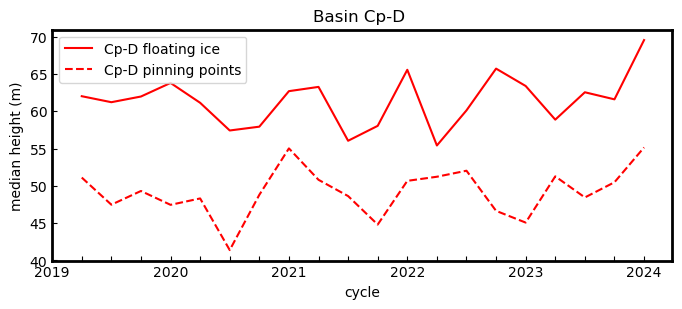

In [859]:
plt.figure(figsize=[8, 3])
plt.plot(mean_cycle.cycle_number, dss.h_med.median(dim=['track', 'pt']), color='red', label='Cp-D floating ice')
plt.plot(mean_cycle_pp.cycle_number, dss_pp.h_med.median(dim=['track', 'pt']), '--', color='red', label='Cp-D pinning points')
# starting at 2 is 2019
#plt.xlim([2, 23])
plt.xticks(ticks=np.arange(2, 23), labels=[f'{int(2018+((c+2)/4))}' if ((c+2)%4)==0 else '' for c in np.arange(2, 23)])
plt.tick_params(direction='in')
plt.xlabel('cycle')
plt.ylabel('median height (m)')
plt.title('Basin Cp-D ')
plt.legend()

In [ ]:
##### old stuff

In [428]:
# Data availability

Text(0, 0.5, 'elevation anomaly (m)')

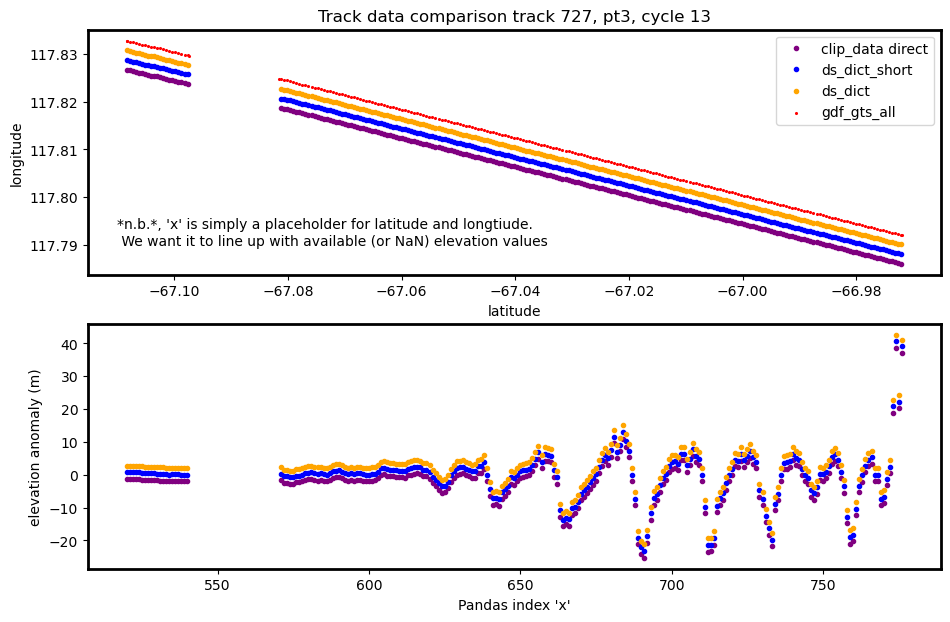

In [429]:
#727
this = gdf_gts_all[197:198]
coords = this.to_crs(crs_latlon).get_coordinates()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[11, 7])
ax1.plot(ds.latitude, ds.longitude-0.004, '.', label='clip_data direct', color='purple')
ax1.plot(ds_dict_short[727].latitude.sel(pt=pt), ds_dict_short[727].longitude.sel(pt=pt)-0.002, '.', label='ds_dict_short', color='blue')
ax1.plot(ds_dict[727].latitude.sel(pt=pt), ds_dict[727].longitude.sel(pt=pt), '.', label='ds_dict', color='orange')
ax1.scatter(coords.y, coords.x+0.002, color='red', label='gdf_gts_all', s=1.5)
ax1.set_title(f'Track data comparison track {track}, {pt}, cycle 13')
ax1.legend()
ax1.set_xlabel('latitude')
ax1.set_ylabel('longitude')
ax1.text(-67.11, 117.79, 
    '*n.b.*, \'x\' is simply a placeholder for latitude and longtiude.\n We want it to line up with available (or NaN) elevation values',
    color='k')
ax2.plot(ds.x, ds.h_ano.sel(cycle_number=13, track=track, pt=pt)-2, '.', label='clip_data direct', color='purple')
ax2.plot(ds_dict_short[727].x, ds_dict_short[727].h_ano.sel(cycle_number=13, pt=pt, track=track), '.', label='ds_dict_short', color='blue')
ax2.plot(ds_dict[727].x, ds_dict[727].h_ano.sel(cycle_number=13, pt=pt, track=track)+2, '.', label='ds_dict', color='orange')
#ax2.set_title(f'Height anomaly comparison track {track}, {pt}, cycle 13')
ax2.set_xlabel(f'Pandas index \'x\'')
ax2.set_ylabel('elevation anomaly (m)')
#plt.savefig('/Users/ccroberts/Desktop/track_comparison_727.png', dpi=200, bbox_inches='tight')

In [1006]:
#Tides and stuff

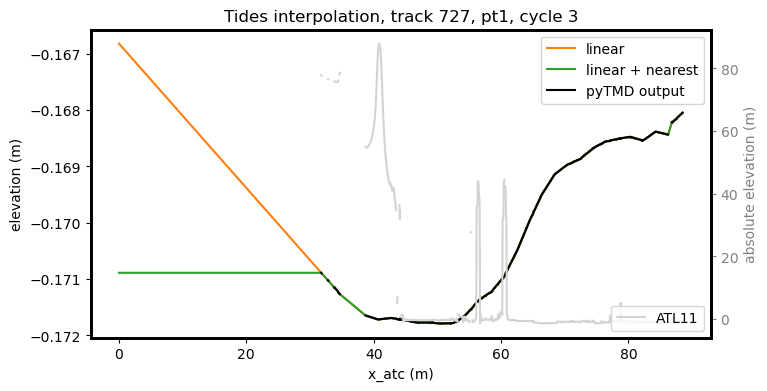

In [1129]:
fig, ax = plt.subplots(figsize=[8, 4])
axt = ax.twinx()
#plt.axvspan(pp[0]/1000, pp[1]/1000, color='lightgray')
axt.plot(ds.x_atc/1000, ds.h_abs.sel(cycle_number=3, track=track, pt=pt), color='lightgrey', label='ATL11')
ax.plot(ds.x_atc/1000, ds.tide_cats.sel(cycle_number=3, track=track, pt=pt))
ax.plot(ds.x_atc/1000, ds.tide_cats.interpolate_na(dim='x', method='linear', fill_value='extrapolate').sel(cycle_number=3, track=track, pt=pt), label='linear')
ax.plot(ds.x_atc/1000, ds.tide_cats.interpolate_na(dim='x', method='linear').interpolate_na(dim='x', method='nearest', fill_value='extrapolate').sel(cycle_number=3, track=track, pt=pt), label='linear + nearest')
ax.plot(ds.x_atc/1000, ds.tide_cats.sel(cycle_number=3, track=track, pt=pt), color='black', label='pyTMD output')
ax.set_title(f'Tides interpolation, track {track}, {pt}, cycle {3}')
ax.set_xlabel('x_atc (m)')
ax.set_ylabel('elevation (m)')
axt.set_ylabel('absolute elevation (m)')
axt.tick_params(colors='grey')
axt.yaxis.label.set_color('grey')
ax.legend()
axt.legend(loc=4)
fig.savefig('/Users/ccroberts/Desktop/tides_interpolation.png', dpi=200, bbox_inches='tight')

In [765]:
# An xarray combine_by_coords test

def combine_by_coords_problem(name, join="outer"):

    da0 = [['a10', 'a20', 'a30'],['b10', 'b20', 'b30'], ['c10', 'c20', 'c30']]
    da1 = [['c40', 'c50', 'c60'], ['d40', 'd50', 'd60']] 
    ds0 = xr.Dataset({'data': (['x1', name], da0)}, coords={"x1": ['a', 'b', 'c'], name: [10, 20, 30]})
    ds1 = xr.Dataset({'data': (['x1', name], da1)}, coords={"x1": ['c', 'd'], name: [40, 50, 60]})

    return xr.combine_by_coords([ds0, ds1], join=join)

#combine_by_coords_problem("x0") # concatenates 1, 2, 3, 4, 5, 6
#combine_by_coords_problem("x2") # concatenates 10, 20, 30, 40, 50, 60

out = combine_by_coords_problem("x2", join='outer')
out.sel(x1='d', x2=50)

<xarray.Dataset> Size: 20B
Dimensions:  ()
Coordinates:
    x1       <U1 4B 'd'
    x2       int64 8B 50
Data variables:
    data     object 8B 'd50'

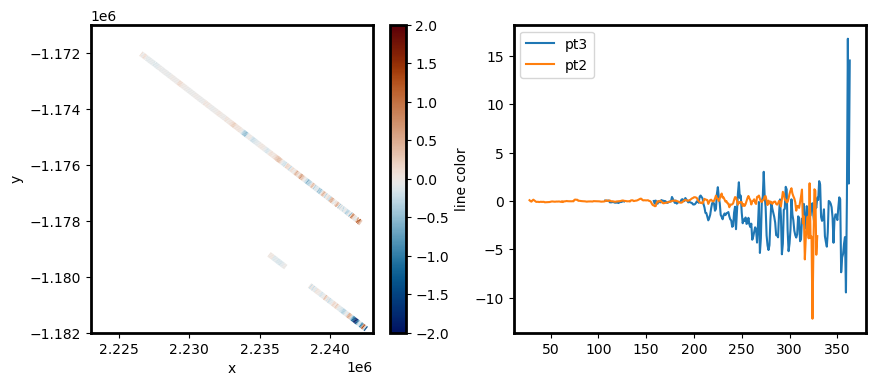

In [502]:
# a line collection test

cmap = cmc.vik
this = gdf_gts_all[197:198]  #track 727
these = [gdf_gts_all[197:198], gdf_gts_all[196:197]]
#these = [gdf_gts_all[196:197]]

# Plotting
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[10, 4])
lc_list = []
for this in these:
    # Prepare segments for LineCollection
    points = np.array([this.get_coordinates().x, this.get_coordinates().y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # Create a LineCollection
    lc = LineCollection(segments, cmap=cmap, label=f'{this.pt.iloc[0]}', norm=plt.Normalize(-2, 2))
    lc.set_array(ds_dict[this.track.iloc[0]].h_ano.mean(dim='cycle_number').sel(track=this.track.iloc[0], pt=this.pt.iloc[0]))
    #lc.set_array(ds_dict[these[1].track.iloc[0]].h_ano.mean(dim='cycle_number').sel(track=these[1].track.iloc[0], pt=these[1].pt.iloc[0]))
    lc.set_linewidth(4)
    lc_list.append(lc)
    
    ax.add_collection(lc)
    ax.autoscale()

    ax1.plot(ds_dict[this.track.iloc[0]].h_ano.mean(dim='cycle_number').sel(track=this.track.iloc[0], pt=this.pt.iloc[0]), 
             label=f'{this.pt.iloc[0]}')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Adding colorbar
cb = fig.colorbar(lc, ax=ax, label='line color')

# Creating a custom legend handle
#cmap_colors = cmap(np.linspace(0, 1, 256))
#cmap_gradient = [patches.Patch(facecolor=c, edgecolor=c, label=cmap.name) for c in cmap_colors]
#ax.legend()#(handles=[cmap_gradient], labels=['color gradient line'], handler_map={list: HandlerTuple(ndivide=None, pad=0)})
ax.set_ylim([-1.182e6, -1.171e6])
ax.set_xlim([2.2230e6, 2.2430e6])
ax1.legend()

